Author : 
Lauren Baillot
Merlin Boyer
Effie Segas

Projet Intelligence Artificielle 3A Robotique ENSEIRB/ENSC

Bibliothèques à importer pour le bon fonctionnement du projet

In [214]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

Définition de la seed

In [215]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

Définition de la classe contenant le réseau

In [216]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.file = open("text/Shakespeare.txt", "r").read().replace('\n', ' ')
        self.resSize = 300
        # taux de fuite alpha (desaprentissage)
        self.a = 0.3
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.reg =  1e-8
        self.mode = 'prediction'
        seed = None #42
        set_seed(seed)

Initialisation du réseau

In [217]:
nw = Network()

4082965787
Seed used for random values: 4082965787


Traitement du texte

Prend le texte
Si keep_upper = True : respecte la casse,
sinon transforme le texte en minuscule.
Si keep_punctuation : garde la ponctuation,
sinon garde le texte sans la ponctuation.
Si keep_numbers : garde les chiffres,
sinon garde le texte sans chiffres.

In [218]:
def filter_characters(nw, keep_upper=True, keep_punctuation=True, keep_numbers=True) :

    alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
    numbers = list("0123456789")

    if keep_upper == False : nw.file = nw.file.lower()
    nw.input_text = list(nw.file)

    if keep_punctuation == False :
        nw.input_text = [i for i in nw.input_text if i in alphabet]     

    if keep_numbers == False :
        nw.input_text = [i for i in nw.input_text if i not in numbers]
    
    return(nw)

Adaptation de filtre caractère pour filtrer des mots

In [296]:
def filter_words(nw, keep_upper=True, keep_punctuation=True, keep_numbers=True):
    
    alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
    numbers = list("0123456789")

    # Met le texte en minuscule si demandé
    if not keep_upper: nw.file = nw.file.lower()
    
    nw.file.replace('\n', ' ')

    # Découpe le texte à chaque espace
    nw.input_text = nw.file.split(" ")
    

    
    # Parcours toute la liste de mots
    for index, words in enumerate(nw.input_text):
        # Sort les ponctuactions
        if not keep_punctuation:
            nw.input_text[index] = ""
            temporaire = [i for i in words if i in alphabet]
            for element in temporaire:
                nw.input_text[index] += str(element)
            if nw.input_text[index] == '':
                del nw.input_text[index]

        # Sort les nombres
        if not keep_punctuation:
            nw.input_text[index] = ""
            temporaire = [i for i in words if i in numbers]
            for element in temporaire:
                nw.input_text[index] += str(element)
            if nw.input_text[index] == '':
                del nw.input_text[index]

    ## Sortir tous les espaces restant
    for index, words in enumerate(nw.input_text):
        if words == ' ' or words == '':
            del nw.input_text[index]


                
                ### Voir si on gère les virgules et les points des nombres à virgule
    
    return(nw)

Création de deux dicos :
    input_units : clef sont les caractères et valeurs sont les positions
    outputs_units : clef sont les valeurs et valeurs sont les caractères
    

In [297]:
def characters(nw) :
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) :
        nw.input_units[item] = i
        nw.output_units[i] = item
    print("\nCaractères existants dans le texte :", sorted(nw.input_units),
          "\nNombre de caractères différents :", len(nw.input_units), "\n")
    return(nw)

Adaptation characters pour mots

In [298]:
def words(nw):
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) :
        nw.input_units[item] = i
        nw.output_units[i] = item
   # print("\nMots existants dans le texte :", sorted(nw.input_units),
   #       "\nNombre de mots différents :", len(nw.input_units), "\n")
    return(nw)


Parcours input_text et pour chaque caractère regarde la valeur correspondante dans
input_units et ajoute dans data (remplace toutes les lettres par leur indices)
Crée la taille des couches entrées et sorties


In [299]:
def convert_input(nw) :
    nw.data = np.array([nw.input_units[i] for i in nw.input_text])
    nw.inSize = nw.outSize = len(nw.input_units)
    return(nw)

Fait des vecteurs binaires
data_b : autant de ligne que de caractères dans le texte et autant de colonnes que de caractères différents dans le texte
Puis met un 1 à l'indice correspondant au caractère.

In [300]:
def binary_data(nw) :
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    for i, item in enumerate(nw.data) :
        nw.data_b[i][item] = 1
    return(nw)

Adaptation pour les mots

In [301]:
def binary_data_words(nw) :
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    for i, item in enumerate(nw.data) :
         nw.data_b[i][item] = 1
    return(nw)

Passage au code de ESN
1) initialise toutes les matrices

In [302]:
def initialization(nw) :
    #set_seed()
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    nw.x = np.zeros((nw.resSize,1))
    return(nw)

2) Calcul du rayon spectrale ( maximum des valeurs propres de la matrice des poids du réservoir)
(fonction mettant à jour les poids)

In [303]:
def compute_spectral_radius(nw):
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

3) Entraine le réseau

In [304]:
def train_network(nw) :
    percent = 0.1
    for t in range(nw.trainLen):
        percent = progression(percent, t, nw.trainLen)
        nw.u = nw.data_b[t%len(nw.data)]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0]      
    return(nw)

4) Met à jour les poids

In [305]:
def train_output(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    return(nw)

5) Test du network

In [306]:
def test(nw) :
    print('Testing the network... (', nw.mode, ' mode)', sep="", end=" ")
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen%len(nw.data)]
    percent = 0.1
    for t in range(nw.testLen):
        percent = progression(percent, t, nw.trainLen)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode: se sert de la sortie précédente pour générer la suivante
            nw.u = nw.y
        elif nw.mode == 'prediction':
            # predictive mode: tente de prédire la sortie suivante
            nw.u = np.zeros(len(nw.input_units))
            nw.u[nw.data[(nw.trainLen+t+1)%len(nw.data)]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    print('done.\n')
    return(nw)

6) Calcul de la meansquare error

In [307]:
def compute_error(nw) :
    print("Computing the error...", end=" ")
    errorLen = 500
    mse = sum( np.square( nw.data[(nw.trainLen+1)%len(nw.data):(nw.trainLen+errorLen+1)%len(nw.data)] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

Traduction de la sortie

In [290]:
def convert_output(nw) :
    nw.output_text = ""
    for i in range(len(nw.Y.T)) :
        nw.output_text += nw.output_units[nw.Y.T[i].argmax()]
    return(nw.output_text)

Calcul de la progression

In [291]:
def progression(percent, i, total) :
    if i == 0 :
        print("Progress :", end= " ")
        percent = 0.1
    elif (i/total) > percent :
        print(round(percent*100), end="")
        print("%", end=" ")
        percent += 0.1
    if total-i == 1 :
        print("100%")
    return(percent)

Applique toutes les fonctions sur le réseau

In [308]:
def compute_network(nw, a, b, c) :
    #nw = filter_characters(nw, a, b, c)
    nw = filter_words(nw,a,b,c)
    #nw = characters(nw)
    nw = words(nw)
    nw = convert_input(nw)
    nw = binary_data_words(nw)
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = train_network(nw)
    nw = train_output(nw)
    nw = test(nw) 
    nw = compute_error(nw)
    nw = convert_output(nw)
    return(nw)

Configure network

In [309]:
select_mode = ToggleButtons(description='Mode:', options=['prediction', 'generative'])
text = Dropdown(description='Text:', options={"Shakespeare (4 573 338 chars.)" : 1, "Sherlock Holmes (3 868 223 chars)" : 2,
                                                   "Harry Potter and the Sorcerer's Stone (439 743 chars.)" : 3,
                                                   "Harry Potter and the Prisoner of Azkaban (611 584 chars.)" : 4}, value = 4)
var1 = Checkbox(description='Keep upper case letters?',value=True,)
var2 = Checkbox(description='Keep punctuation?',value=True,)
var3 = Checkbox(description='Keep numbers?',value=True,)
var4 = FloatSlider(value=300, min=0, max=5000, step=1, description='resSize')
var5 = FloatText(value=1000, description='initLen')
var6 = FloatText(value=10000, description='trainLen')
var7 = FloatText(value=2000, description='testLen')
var8 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var9 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Validate')

def record_values(_):
    clear_output()
    nw.mode=select_mode.value
    file = text.value
    texts = ["Shakespeare.txt", "SherlockHolmes.txt", "HarryPotter1.txt", "HarryPotter3.txt"]
    nw.file = open("text/"+texts[file-1], "r").read().replace('\n', ' ')
    nw.resSize=int(var4.value)
    nw.initLen=int(var5.value)
    nw.trainLen=int(var6.value)
    nw.testLen=int(var7.value)
    nw.spectral_radius=float(var8.value)
    nw.a=float(var9.value)
    
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    
    print(file)
    compute_network(nw, var1.value, var2.value, var3.value)
    return(nw.output_text)

display(select_mode)
display(text)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(var7)
display(var8)
display(var9)
display(valid)

output_text = valid.on_click(record_values)

InitLen: 1000 TrainLen: 10000 TestLen: 2000
ResSize: 300 Spectral Radius: 1.25 Leak Rate: 0.3
4


IndexError: list assignment index out of range

Montrer le texte

In [76]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)

display(valid3)
valid3.on_click(show_output)

Button(description='Show the output!', style=ButtonStyle())

Adapatation de show_output pour mots

In [52]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)

display(valid3)
valid3.on_click(show_output)

Button(description='Show the output!', style=ButtonStyle())

NameError: name 'nw' is not defined

AttributeError: 'Network' object has no attribute 'output_text'

Affichage des caractères dans le texte

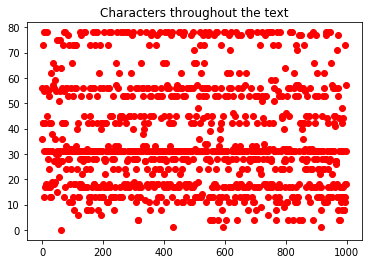

In [78]:
var10 = FloatText(value=1000, description='Number of chars')
valid2 = Button(description='Validate')
        
def trace_graph1(_) :
    clear_output()
    plt.figure(1).clear()
    limit = np.arange(int(var10.value))
    plt.plot(limit,nw.data[0:int(var10.value)], 'ro')
    plt.title('Characters throughout the text')
    
valid2.on_click(trace_graph1)
    
display(var10)
display(valid2)

In [174]:
import numpy as np

mots = "Le CHAT chat est dans 5 cuisines.\n"


keep_upper=False
keep_punctuation=False
keep_numbers=False 
keep_spaces=True
    
alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
numbers = list("0123456789")

# Met le texte en minuscule si demandé
if not keep_upper: mots = mots.lower()
    
# Remplace saut de ligne par espace
temp.replace('\n', '')
# Découpe le texte à chaque espace
temp = mots.split(" ")
    
# Parcours toute la liste de mots
for index, words in enumerate(temp):
    # Sort les ponctuactions
    if not keep_punctuation:
        temp[index] = ""
        temporaire = [i for i in words if i in alphabet]
        for element in temporaire:
            temp[index] += str(element)
        if temp[index] == '':
            del temp[index]
            

    # Sort les nombres
    if not keep_numbers:
        temp[index] = ""
        temporaire = [i for i in words if i not in numbers]
        for element in temporaire:
            temp[index] += str(element)
        if temp[index] == '':
            del temp[index]
    
print(temp)

input_units, output_units = dict(), dict()
for i, item in enumerate(set(temp)) :
    input_units[item] = i
    output_units[i] = item
print("\nMots existants dans le texte :", sorted(input_units),
        "\nNombre de mots différents :", len(input_units), "\n")

print(input_units)
print(output_units)

data = np.array([input_units[i] for i in temp])
inSize = outSize = len(input_units)

print(data)

AttributeError: 'list' object has no attribute 'replace'

In [310]:
print(len(nw.input_text))
print(len(nw.input_units))
print(nw.input_units)
nw.data_b = np.zeros((1,len(nw.input_units)))

nw.data_b

nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))


53822
15517
{'': 0, 'Howler': 1, 'murdered': 2, 'remembered': 3, 'roots,': 4, 'whole': 5, 'glory': 6, 'ghosts': 7, 'Ministry,': 8, 'else': 9, 'life-threatening,"': 10, 'was....': 11, 'aloud!"': 12, 'Hogwarts.\'"': 13, 'Do': 14, 'hurt.': 15, 'situation,': 16, 'mess.': 17, 'flame-loving': 18, 'twitching.': 19, 'stifled': 20, 'hammered,': 21, 'flourish': 22, 'wings,': 23, 'season.': 24, 'complete': 25, 'slept': 26, 'isolated.': 27, 'Hermione."': 28, 'belt;': 29, 'gray,': 30, 'entrances.': 31, 'leaves!"': 32, 'sunken': 33, '"Help': 34, 'grinning': 35, 'Unless"': 36, 'breathless,': 37, 'mock': 38, 'hit."': 39, 'today.': 40, 'mistake,"': 41, '"What?': 42, 'HAVE': 43, 'safest': 44, 'boy?"': 45, 'cover': 46, 'Peeves,': 47, 'scrub': 48, 'polite,': 49, 'weapons': 50, 'heavens': 51, 'Crookshanks;': 52, 'remarkable': 53, '"THAT\'S': 54, 'guide': 55, "what'll": 56, 'sliding': 57, 'palm.': 58, 'office,': 59, 'just': 60, 'arm': 61, 'ago': 62, 'noticed': 63, 'trees.': 64, 'Sitting': 65, 'Class,': 66, 

In [213]:
file = open("text/Shakespeare.txt", "r").read().replace('\n', ' ')

file.replace('\n', ' ')

text = file.split(' ')
text

['First',
 'Citizen:',
 'Before',
 'we',
 'proceed',
 'any',
 'further,',
 'hear',
 'me',
 'speak.',
 '',
 'All:',
 'Speak,',
 'speak.',
 '',
 'First',
 'Citizen:',
 'You',
 'are',
 'all',
 'resolved',
 'rather',
 'to',
 'die',
 'than',
 'to',
 'famish?',
 '',
 'All:',
 'Resolved.',
 'resolved.',
 '',
 'First',
 'Citizen:',
 'First,',
 'you',
 'know',
 'Caius',
 'Marcius',
 'is',
 'chief',
 'enemy',
 'to',
 'the',
 'people.',
 '',
 'All:',
 'We',
 "know't,",
 'we',
 "know't.",
 '',
 'First',
 'Citizen:',
 'Let',
 'us',
 'kill',
 'him,',
 'and',
 "we'll",
 'have',
 'corn',
 'at',
 'our',
 'own',
 'price.',
 "Is't",
 'a',
 'verdict?',
 '',
 'All:',
 'No',
 'more',
 'talking',
 "on't;",
 'let',
 'it',
 'be',
 'done:',
 'away,',
 'away!',
 '',
 'Second',
 'Citizen:',
 'One',
 'word,',
 'good',
 'citizens.',
 '',
 'First',
 'Citizen:',
 'We',
 'are',
 'accounted',
 'poor',
 'citizens,',
 'the',
 'patricians',
 'good.',
 'What',
 'authority',
 'surfeits',
 'on',
 'would',
 'relieve',
 'us:',